<center>
<img align="center" width="900" height="220" src="https://upload.wikimedia.org/wikipedia/commons/8/8a/Logo_Nutella.svg">
</center>

# **Nutella Demand Forecasting**: Concept Exploration

[Jose Manuel Gutierrez Castellanos](www.linkedin.com/in/josemanuelgutierrez17) \([josemanugtz@live.com](josemanugtz@live.com))

### Table of Contents

- [Section 1: Load packages and libraries](#section-1)
- [Section 2: Exploratory Data Analysis](#section-2)
- [Section 3: Machine Learning Model](#section-3)


<a id='section-1'></a>
# **Section 1:** Load packages and libraries

In [115]:
# === Data Manipulation ===
import pandas as pd
import numpy as np
import os

# === Plotting ===
import matplotlib.pyplot as plt
import seaborn as sns
from utils import * 

# === Machine Learning ===
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, TimeSeriesSplit
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor, Pool
from xgboost import XGBRegressor
import joblib
import scipy.stats as stats


<a id='section-2'></a>
# **Section 2:** Exploratory Data Analysis

In [59]:
DATA_PATH = 'data/synthetic/nutella_sales.csv'
df_nutella = pd.read_csv(DATA_PATH)

# Load data into dataframe
print("Shape Train: ",df_nutella.shape)
df_nutella.head()

Shape Train:  (1096, 17)


,Date,Regular_Price,Discounted_Price,Discount_Rate,Promotion_Type,Promotion_Duration,Month,Month_Sin,Month_Cos,Day_of_Week,Is_Holiday,Supermarket_Type,Location_Type,Store_Traffic,Planned_Promotions_7_Days,Planned_Promotions_30_Days,Sales_Volume
0,2023-01-01,5.0,5.000000,0.000000,NaN,0,1,0.5,0.866025,6,0,Big,Suburban,708,0,0,121
1,2023-01-02,5.0,5.000000,0.000000,NaN,0,1,0.5,0.866025,0,0,Big,City Center,1176,0,0,115
2,2023-01-03,5.0,5.000000,0.000000,NaN,0,1,0.5,0.866025,1,0,Medium,Suburban,655,0,0,109
3,2023-01-04,5.0,4.460409,0.107918,Percentage,1,1,0.5,0.866025,2,0,Big,Suburban,668,0,0,132
4,2023-01-05,5.0,5.000000,0.000000,Flash Sale,1,1,0.5,0.866025,3,0,Medium,Suburban,573,0,0,141


### **Section 2.1:** Dataframe Loading & General Info

- **Source**: Synthetic Dataset (Generated for Proof of Concept)
- **Purpose**: Predict Nutella sales volume based on promotions, discounts, and supermarket types.
- **File**: `nutella_sales.csv`
- **Total Rows**: 1,096
- **Total Columns**: 17
- **Key Features**:
  - **Date** → Date of the sales record (Year-Month-Day)
  - **Regular_Price** → Original price of Nutella before discount
  - **Discounted_Price** → Price after discount is applied
  - **Discount_Rate** → Percentage discount applied on Nutella
  - **Promotion_Type** → Type of promotion (e.g., Flash Sale, Percentage)
  - **Promotion_Duration** → Duration of the promotion in days
  - **Month** → Extracted month from the Date
  - **Day_of_Week** → Day of the week (e.g., Monday, Tuesday)
  - **Is_Holiday** → Whether the day is a holiday (0 = No, 1 = Yes)
  - **Supermarket_Type** → Type of supermarket (e.g., Big, Small)
  - **Location_Type** → Location of the supermarket (e.g., Urban, Suburban, Rural)
  - **Store_Traffic** → Estimated foot traffic in the store
  - **Planned_Promotions_7_Days** → Number of planned promotions in the next 7 days
  - **Planned_Promotions_30_Days** → Number of planned promotions in the next 30 days
  - **Sales_Volume** → Number of Nutella jars sold per day (Target Variable)
  - **Month_Sin, Month_Cos** → Cyclic encoding of the month for seasonality detection

In [62]:
# Columns present in the dataset
print('Columns:', df_nutella.columns)
print('General Information:', df_nutella.info())

Columns: Index(['Date', 'Regular_Price', 'Discounted_Price', 'Discount_Rate',
       'Promotion_Type', 'Promotion_Duration', 'Month', 'Month_Sin',
       'Month_Cos', 'Day_of_Week', 'Is_Holiday', 'Supermarket_Type',
       'Location_Type', 'Store_Traffic', 'Planned_Promotions_7_Days',
       'Planned_Promotions_30_Days', 'Sales_Volume'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1096 entries, 0 to 1095
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Date                        1096 non-null   object 
 1   Regular_Price               1096 non-null   float64
 2   Discounted_Price            1096 non-null   float64
 3   Discount_Rate               1096 non-null   float64
 4   Promotion_Type              202 non-null    object 
 5   Promotion_Duration          1096 non-null   int64  
 6   Month                       1096 non-null   int64  
 7   Month_Sin    

### **Section 2.2:** Data cleaning

In [ ]:
# Check for missing values
print("Missing values in the Data:")
print(df_nutella.isnull().sum())
print("Basic Statistics:")
print('Basic Statistics:', df_nutella.describe())
# The dataset contains null values in the Promotion Type, since not always a discount is applied

Missing values in the Data:
Date                            0
Regular_Price                   0
Discounted_Price                0
Discount_Rate                   0
Promotion_Type                894
Promotion_Duration              0
Month                           0
Month_Sin                       0
Month_Cos                       0
Day_of_Week                     0
Is_Holiday                      0
Supermarket_Type                0
Location_Type                   0
Store_Traffic                   0
Planned_Promotions_7_Days       0
Planned_Promotions_30_Days      0
Sales_Volume                    0
dtype: int64
Basic Statistics:
Basic Statistics:        Regular_Price  Discounted_Price  Discount_Rate  Promotion_Duration  \
count         1096.0       1096.000000    1096.000000         1096.000000   
mean             5.0          4.904264       0.019147            0.443431   
std              0.0          0.390706       0.078141            1.047935   
min              5.0          2.50250

In [66]:
# Convert 'Date' to datetime format
df_nutella['Date'] = pd.to_datetime(df_nutella['Date'])
df_nutella['Month'] = df_nutella['Date'].dt.month

# Identify numerical columns
numerical_cols = df_nutella.select_dtypes(include=['number']).columns

### **Section 2.3:** Analysis and pattern discovery

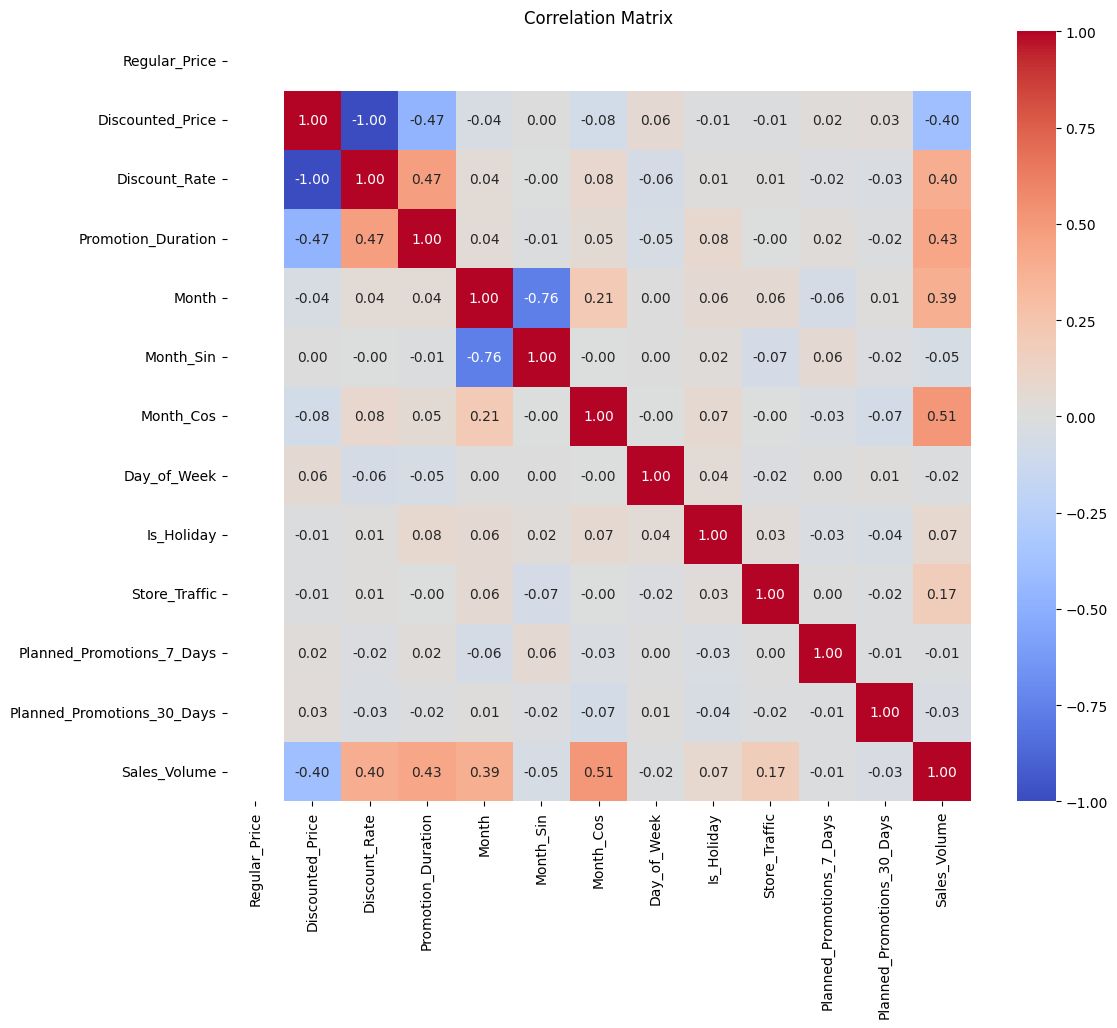

In [ ]:
# 1. Correlation Matrix

corr_matrix = df_nutella[numerical_cols].corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

# Key Observations
- The strongest positive correlations with 'Sales_Volume' are:
  - *Discount_Rate* (0.43) and *Promotion_Duration* (0.39): Higher discounts and longer promotions result in higher sales, suggesting promotions are effective.
  - *Month_Cos* (0.51) and *Month* (0.39): There are potential seasonal trends, where certain months show higher sales, indicating seasonality is an important factor.
  - *Store_Traffic* (0.17): Higher foot traffic slightly increases sales, although the correlation is relatively weak.

- Negative correlations:
  - *Regular_Price* (-0.40) and *Discounted_Price* (-0.40): Higher prices reduce sales volume, highlighting the importance of pricing strategy.
  - *Planned_Promotions_30_Days* (-0.14) and *Planned_Promotions_7_Days* (-0.10): Future planned promotions might discourage immediate purchases, but the impact is minor.

- Insignificant correlations:
  - *Day_of_Week*, *Month_Sin*: These variables do not show strong relationships with *Sales_Volume*, suggesting they may not be useful for prediction.

- Multicollinearity:
  - *Regular_Price* and *Discounted_Price* are perfectly negatively correlated (-1.00), which makes sense since *Discounted_Price* is derived from *Regular_Price*.
  - *Discount_Rate* is also highly correlated with these two variables.

Text(0, 0.5, 'Frequency')

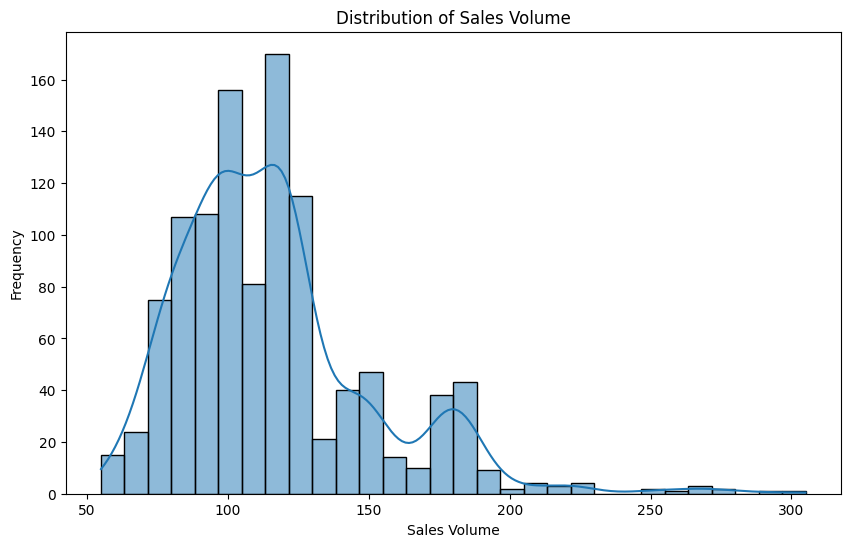

In [110]:
# 2. Distribution of Sales Volume
plt.figure(figsize=(10, 6))
sns.histplot(df_nutella['Sales_Volume'], bins=30, kde=True)
plt.title('Distribution of Sales Volume')
plt.xlabel('Sales Volume')
plt.ylabel('Frequency')

# Key Observations 
- The distribution of *Sales Volume* is approximately normal with a slight right skew.
- The most common sales volume range is between 80 and 160 units per day.
- There are occasional higher sales (around 250 units), likely due to promotional events or specific seasonal periods.

(array([19358., 19478., 19601., 19723., 19844., 19967., 20089., 20209.,
        20332., 20454.]),
 [Text(19358.0, 0, '2023-01'),
  Text(19478.0, 0, '2023-05'),
  Text(19601.0, 0, '2023-09'),
  Text(19723.0, 0, '2024-01'),
  Text(19844.0, 0, '2024-05'),
  Text(19967.0, 0, '2024-09'),
  Text(20089.0, 0, '2025-01'),
  Text(20209.0, 0, '2025-05'),
  Text(20332.0, 0, '2025-09'),
  Text(20454.0, 0, '2026-01')])

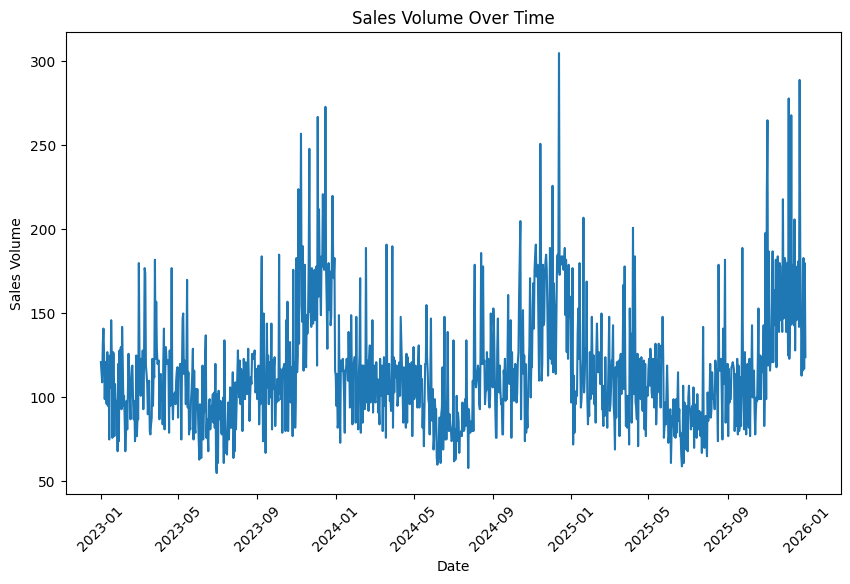

In [ ]:
# 3. Sales Volume Over Time
plt.figure(figsize=(10, 6))
sns.lineplot(x='Date', y='Sales_Volume', data=df_nutella)
plt.title('Sales Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Sales Volume')
plt.xticks(rotation=45)

# Key Observations
- Clear seasonality can be observed with peaks around the middle of each year, suggesting seasonal trends (holiday periods).
- Sales volume increases during certain months of the year, aligning with the positive correlation found with *Month* and *Month_Cos*.
- There are spikes in sales volume that are likely due to promotional events or special sales.
- Periods of lower sales volume are also evident, indicating potential off-season or low promotion periods.

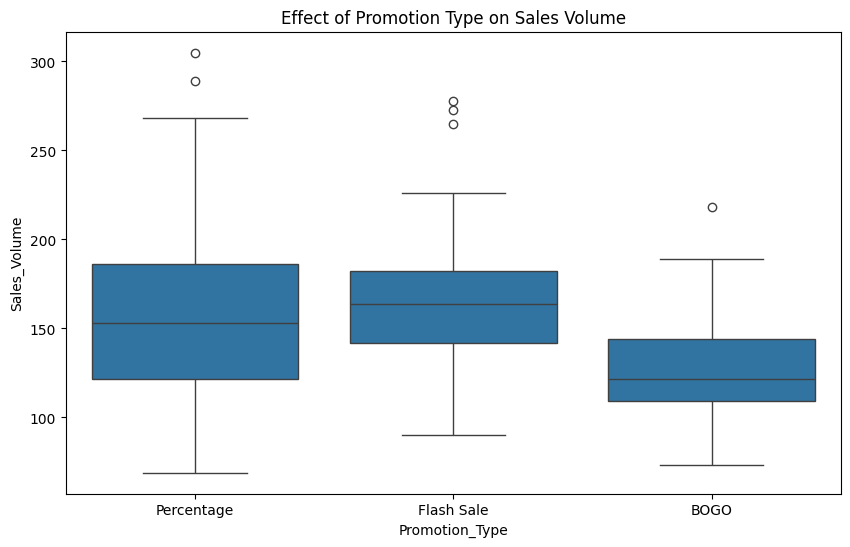

In [ ]:
# 4. Promotion Type Effect on Sales Volume
plt.figure(figsize=(10, 6))
sns.boxplot(x='Promotion_Type', y='Sales_Volume', data=df_nutella)
plt.title('Effect of Promotion Type on Sales Volume')

# Key Observations
- *Percentage* promotions generally result in higher sales compared to *Flash Sales* and *BOGO (Buy One, Get One)* promotions.
- *BOGO* promotions have the lowest median sales volume, indicating they may be less effective.
- *Percentage* promotions show the highest overall sales volume distribution.

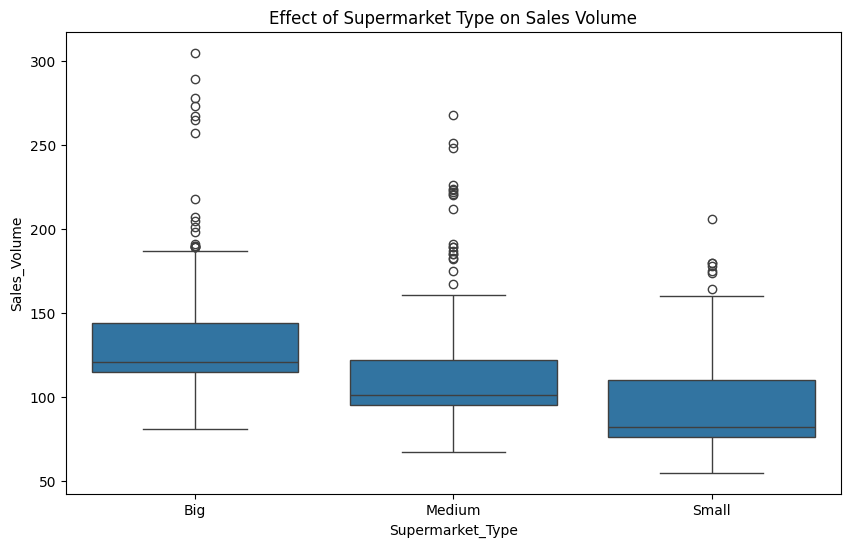

In [ ]:
# 5. Supermarket Type Effect on Sales Volume
plt.figure(figsize=(10, 6))
sns.boxplot(x='Supermarket_Type', y='Sales_Volume', data=df_nutella)
plt.title('Effect of Supermarket Type on Sales Volume')

# Key Observations
- *Big* supermarkets generally have higher median sales compared to *Medium* and *Small* supermarkets.
- The sales distribution is broader for *Big* supermarkets, suggesting they might have a higher impact from promotions.
- Smaller supermarkets show lower overall sales volume, indicating that their influence on total sales is less significant.
- Marketing strategies can be tailored differently depending on the supermarket type.

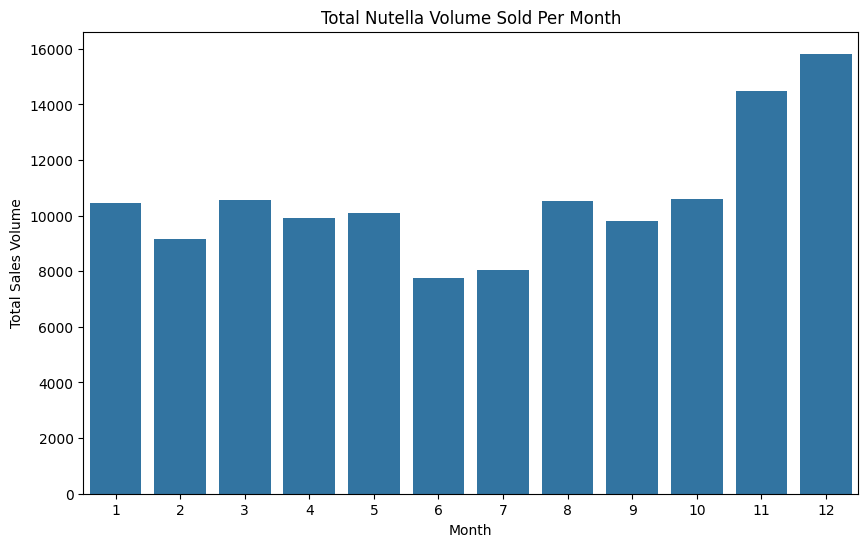

In [ ]:
# 6. Monthly Sales Volume Analysis
monthly_sales = df_nutella.groupby('Month')['Sales_Volume'].sum().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(x='Month', y='Sales_Volume', data=monthly_sales)
plt.title('Total Nutella Volume Sold Per Month')
plt.xlabel('Month')
plt.ylabel('Total Sales Volume')

# Key Observations
- December shows the highest sales volume, indicating increased demand during the holiday season.
- January and February also have relatively high sales, potentially due to New Year promotions.
- The lowest sales are observed during mid-year months, particularly in June and July.
- There is a clear seasonality pattern.

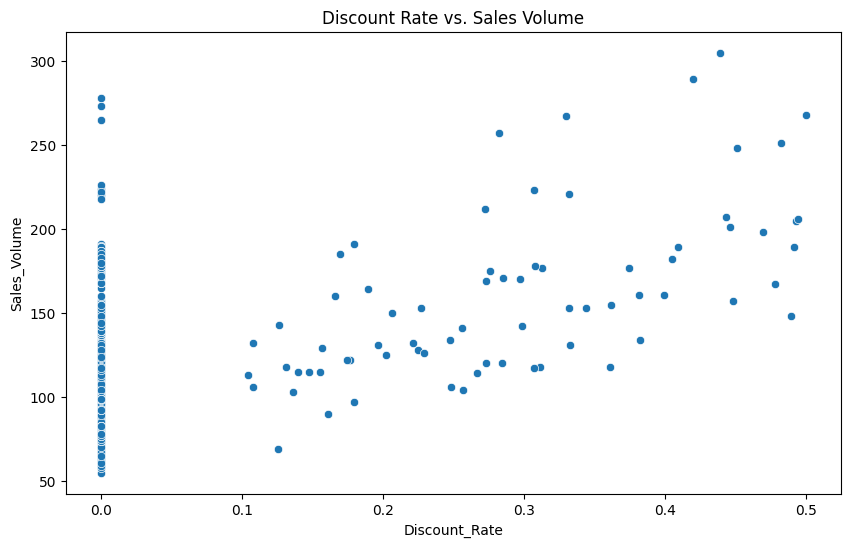

In [ ]:
# 7. Discount Rate vs Sales Volume
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Discount_Rate', y='Sales_Volume', data=df_nutella)
plt.title('Discount Rate vs. Sales Volume')
plt.savefig('data/synthetic/discount_rate_vs_sales_volume.png')

# Key Observations
- There is a noticeable positive relationship between the Discount Rate and Sales Volume.
- As the discount rate increases, sales volume generally increases.
- There are clusters of data points at different discount levels, suggesting that certain discount rates are used more frequently.

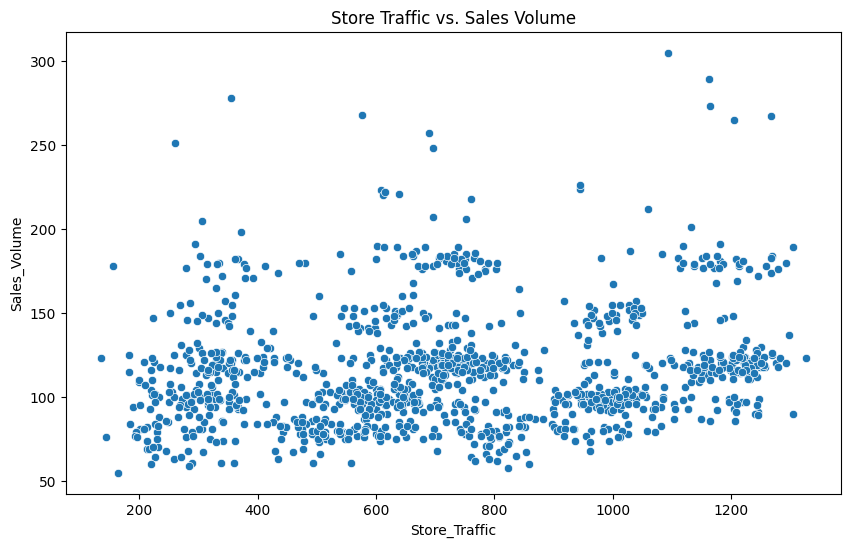

In [ ]:
# 8. Store Traffic vs Sales Volume
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Store_Traffic', y='Sales_Volume', data=df_nutella)
plt.title('Store Traffic vs. Sales Volume')
plt.savefig('data/synthetic/store_traffic_vs_sales_volume.png')

# Key Observations
- There is a positive correlation between Store Traffic and Sales Volume, but it is not very strong.
- Higher store traffic generally results in higher sales volume, but there are also cases where high traffic doesn't lead to high sales.
- Factors like promotion type and discounts may affect sales volume despite high store traffic.

<a id='section-3'></a>
# **Section 3:** Machine Learning Model

In [84]:
# Encoding Categorical Variables
# One-hot encode categorical variables
categorical_features = ['Promotion_Type', 'Supermarket_Type', 'Location_Type', 'Day_of_Week']
encoder = OneHotEncoder(sparse_output=False, drop='first')
df_encoded = pd.DataFrame(encoder.fit_transform(df_nutella[categorical_features]),
                          columns=encoder.get_feature_names_out(categorical_features))

df_nutella = pd.concat([df_nutella, df_encoded], axis=1)
df_nutella.drop(categorical_features, axis=1, inplace=True)

In [85]:
df_nutella.head()

,Date,Regular_Price,Discounted_Price,Discount_Rate,Promotion_Duration,Month,Month_Sin,Month_Cos,Is_Holiday,Store_Traffic,...,Supermarket_Type_Medium,Supermarket_Type_Small,Location_Type_Rural,Location_Type_Suburban,Day_of_Week_1,Day_of_Week_2,Day_of_Week_3,Day_of_Week_4,Day_of_Week_5,Day_of_Week_6
0,2023-01-01,5.0,5.000000,0.000000,0,1,0.5,0.866025,0,708,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2023-01-02,5.0,5.000000,0.000000,0,1,0.5,0.866025,0,1176,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2023-01-03,5.0,5.000000,0.000000,0,1,0.5,0.866025,0,655,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3,2023-01-04,5.0,4.460409,0.107918,1,1,0.5,0.866025,0,668,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4,2023-01-05,5.0,5.000000,0.000000,1,1,0.5,0.866025,0,573,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
# Definition of features, target and feature scaling
features = df_nutella.drop(['Date', 'Sales_Volume'], axis=1)
target = df_nutella['Sales_Volume']

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

In [87]:
# Train, Val, Test splits
# Split for train has been defined to cover 80% of the data for each month, to
# cover patterns hidden in each month. This strategy works better than performing
# the split based on the dataset length

df_nutella['Scaled_Features'] = list(features_scaled)
train_data = pd.DataFrame()
val_data = pd.DataFrame()
test_data = pd.DataFrame()

for month in df_nutella['Month'].unique():
    month_data = df_nutella[df_nutella['Month'] == month]
    train_split = int(0.8 * len(month_data))
    val_split = int(0.9 * len(month_data))

    train_data = pd.concat([train_data, month_data.iloc[:train_split]])
    val_data = pd.concat([val_data, month_data.iloc[train_split:val_split]])
    test_data = pd.concat([test_data, month_data.iloc[val_split:]])


X_train = np.vstack(train_data['Scaled_Features'])
y_train = train_data['Sales_Volume']

X_val = np.vstack(val_data['Scaled_Features'])
y_val = val_data['Sales_Volume']

X_test = np.vstack(test_data['Scaled_Features'])
y_test = test_data['Sales_Volume']

### **Random Forest** Model training

In [91]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

### **XGBoost** Model training

In [88]:
xgb_model = XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=6, random_state=42,
                         reg_alpha=0.1, reg_lambda=0.1)

xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

### **Catboost** Model training

In [89]:
cat_model = CatBoostRegressor(iterations=500, learning_rate=0.03, silent=True, random_state=42,
                              l2_leaf_reg=3)

cat_model.fit(X_train, y_train)

In [92]:
# Model predictions on val and test set
val_preds_xgb = xgb_model.predict(X_val)
val_preds_cat = cat_model.predict(X_val)
val_preds_rf = rf_model.predict(X_val)

test_preds_xgb = xgb_model.predict(X_test)
test_preds_cat = cat_model.predict(X_test)
test_preds_rf = rf_model.predict(X_test)

In [ ]:
# Ensemble model with Weighted Average
# The idea behinf the weighted avg is to give more importance to the models that
# have better performance on the validation set, therefore the ensemble take advantage
# of the strengths of each model.

xgb_rmse_val = np.sqrt(mean_squared_error(y_val, val_preds_xgb))
cat_rmse_val = np.sqrt(mean_squared_error(y_val, val_preds_cat))
rf_rmse_val = np.sqrt(mean_squared_error(y_val, val_preds_rf))

xgb_weight = 1 / xgb_rmse_val
cat_weight = 1 / cat_rmse_val
rf_weight = 1 / rf_rmse_val

total_weight = xgb_weight + cat_weight + rf_weight

xgb_weight /= total_weight
cat_weight /= total_weight
rf_weight /= total_weight

ensemble_preds = (xgb_weight * test_preds_xgb) + (cat_weight * test_preds_cat) + (rf_weight * test_preds_rf)

In [116]:
# Evaluation of the ML-models

results = {}

results['XGBoost'] = evaluate_model(y_test, test_preds_xgb)
results['CatBoost'] = evaluate_model(y_test, test_preds_cat)
results['RandomForest'] = evaluate_model(y_test, test_preds_rf)
results['Ensemble'] = evaluate_model(y_test, ensemble_preds)


# Print Evaluation Results
for model_name, (mae, rmse) in results.items():
    print(f"\n{model_name} - Testing MAE: {mae:.2f}, Testing RMSE: {rmse:.2f}")


XGBoost - Testing MAE: 5.10, Testing RMSE: 6.99

CatBoost - Testing MAE: 4.55, Testing RMSE: 5.64

RandomForest - Testing MAE: 5.11, Testing RMSE: 6.72

Ensemble - Testing MAE: 4.79, Testing RMSE: 6.06


Text(0, 0.5, 'RMSE')

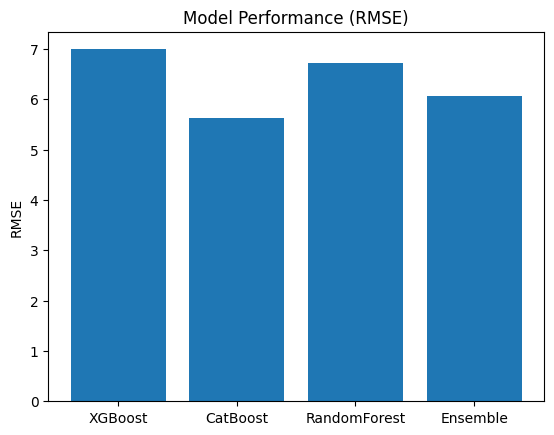

In [ ]:
# Performance Comparison
fig, ax = plt.subplots()
model_names = list(results.keys())
maes = [result[0] for result in results.values()]
rmses = [result[1] for result in results.values()]
ax.bar(model_names, rmses)
ax.set_title("Model Performance (RMSE)")
ax.set_ylabel("RMSE")

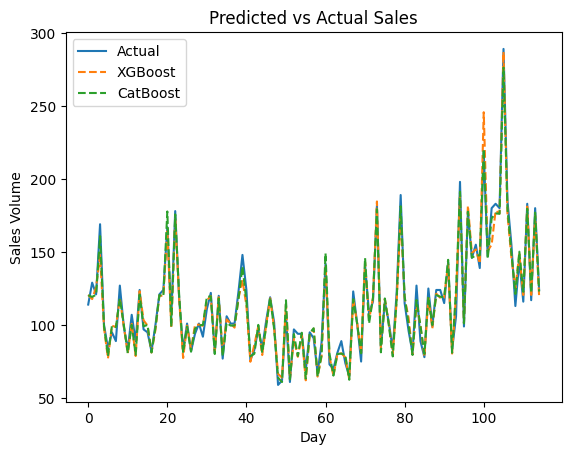

In [ ]:
# Predicted vs. Actual Sales
plt.figure()
plt.plot(y_test.values, label='Actual')
plt.plot(test_preds_xgb, label='XGBoost', linestyle='--')
plt.plot(test_preds_cat, label='CatBoost', linestyle='--')
#plt.plot(test_preds_rf, label='RandomForest', linestyle='--')
#plt.plot(ensemble_preds, label='Ensemble', linestyle='-.')
plt.title("Predicted vs Actual Sales")
plt.xlabel("Day")
plt.ylabel("Sales Volume")
plt.legend()

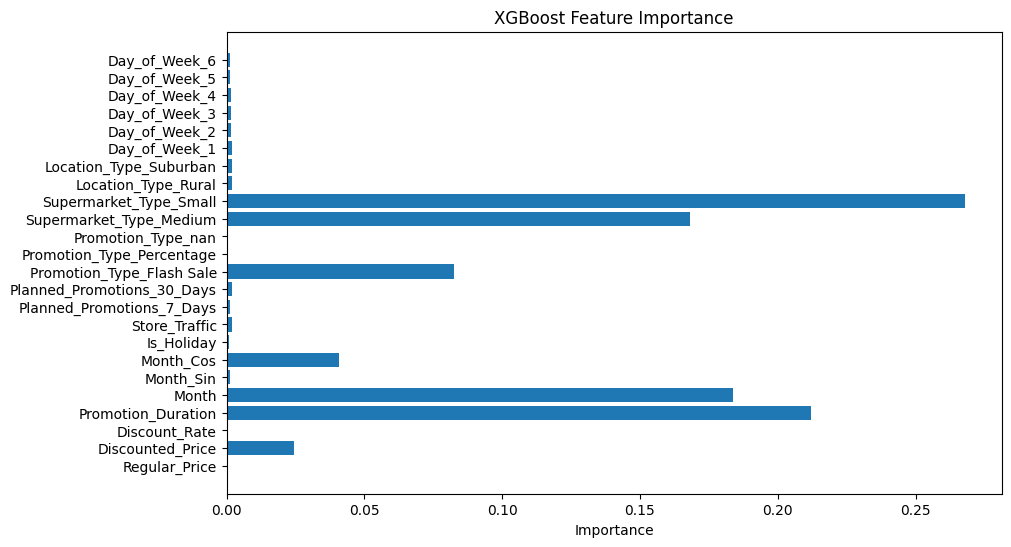

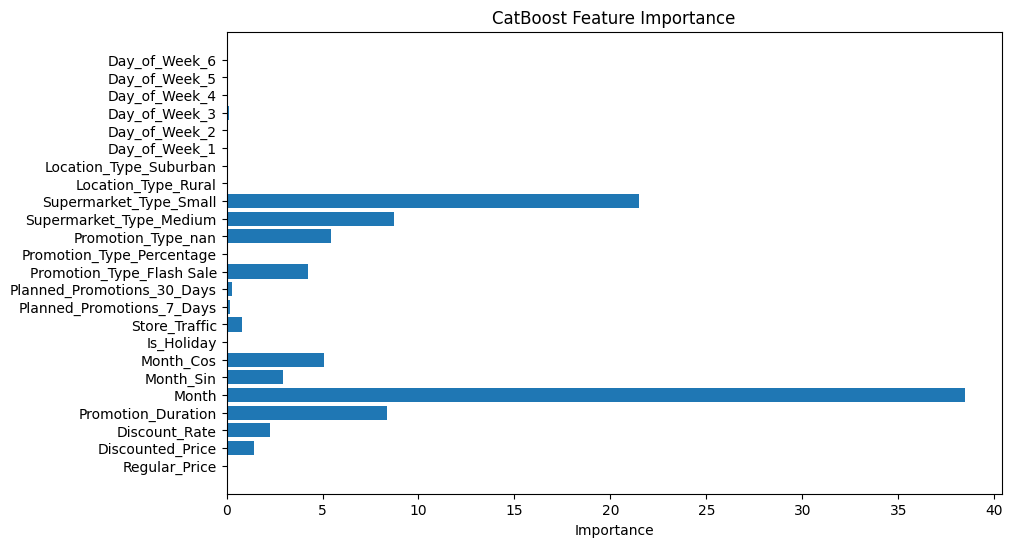

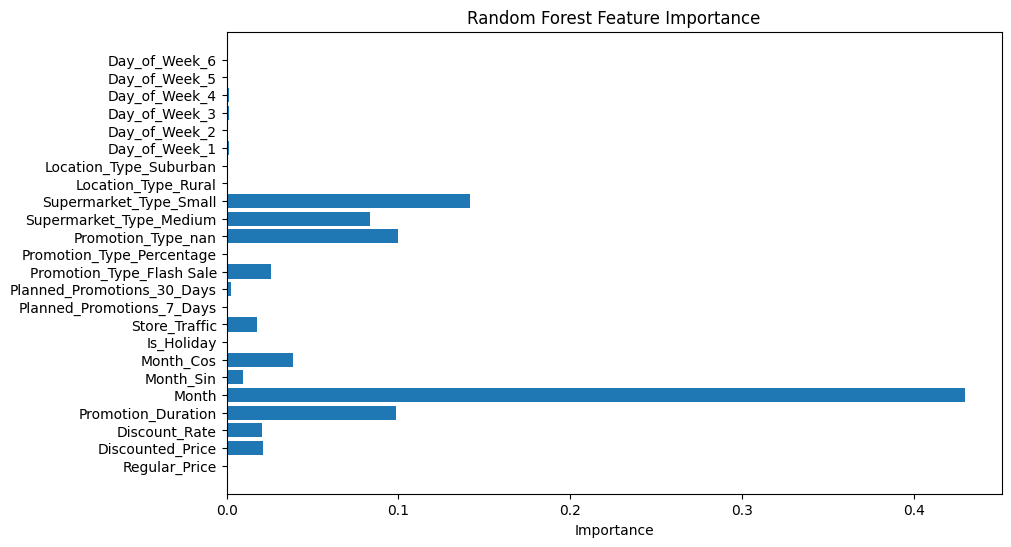

In [ ]:
# Feature Importance based on each model
features_list = features.columns

plot_feature_importance(xgb_model, 'XGBoost', features_list)
plot_feature_importance(cat_model, 'CatBoost', features_list)
plot_feature_importance(rf_model, 'Random Forest', features_list)

Text(0.5, 1.0, 'Ensemble Model Weight Distribution')

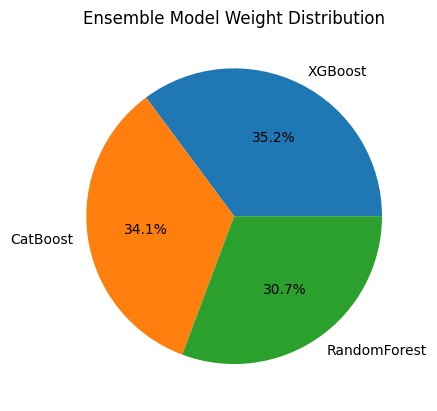

In [ ]:
# Weight Distribution
plt.figure()
plt.pie([xgb_weight, cat_weight, rf_weight], labels=['XGBoost', 'CatBoost', 'RandomForest'], autopct='%1.1f%%')
plt.title('Ensemble Model Weight Distribution')

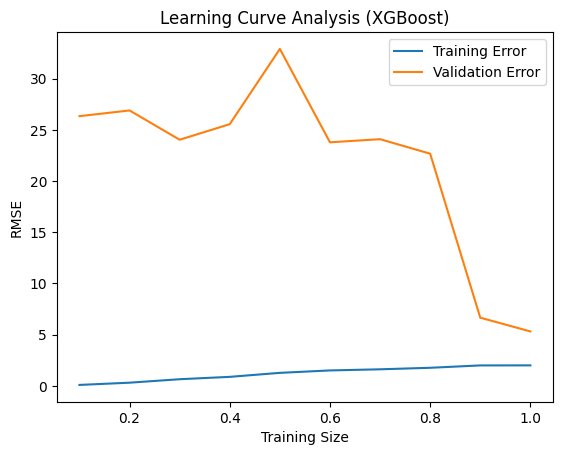

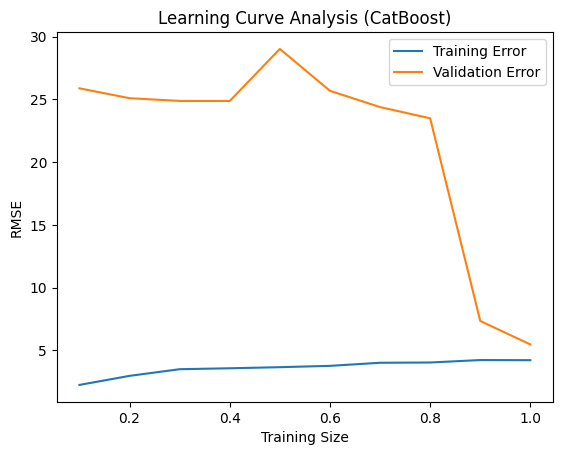

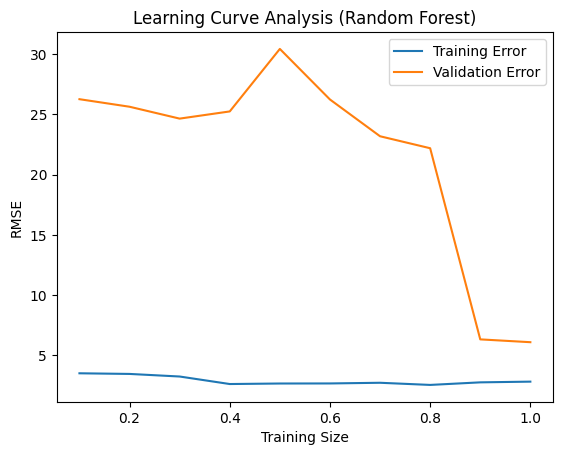

In [117]:
# Learning curves (Train vs Validation)
plot_learning_curve(xgb_model, 'XGBoost', X_train, y_train, X_val, y_val)
plot_learning_curve(cat_model, 'CatBoost', X_train, y_train, X_val, y_val)
plot_learning_curve(rf_model, 'Random Forest', X_train, y_train, X_val, y_val)